In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from sklearn.preprocessing import Normalizer
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('train_weekly.csv')
df['Time']=pd.to_datetime(df['Time'])#,format='%Y-%m-%d')
df=df.iloc[:,:]
df=df.drop(['Signal'],axis=1)
dp=np.zeros(len(df))
pp=np.zeros(len(df))
for i in range(1,len(df)):
    dp[i]=df['AM_NetPos'][i]-df['AM_NetPos'][i-1]
    pp[i]=df['AM_NetPos'][i-1]
df['DP']=dp
df['Prev_pos']=pp
df=df.drop(["Lev_NetPos","AM_n_L","AM_n_S","Lev_n_L","Lev_n_S","AM_L","AM_S","Lev_L","Lev_S",'AM_NetPos','Time'],axis=1).drop(0)

In [3]:
y=df['DP']
X=df.drop(['DP'],axis=1)
X = sm.add_constant(X)
model_OLS = sm.OLS(y, X).fit()
a=model_OLS.pvalues
for i in range(5):
    X_loop=X.iloc[i:,:]
    y_loop=y.shift(i).dropna()
    X_loop = sm.add_constant(X_loop)
    model_OLS = sm.OLS(y_loop, X_loop).fit()
    a+=model_OLS.pvalues
# print(a.sort_values())
selected=['Prev_pos', 'GOLD_price', 'JNK_Volume', 'NASDAQCOM','WILL5000INDFC', 'SPX', 'Libor 6 mo']

# VAR

In [4]:
# deal with the extra lag for positioning
Varmax_df=df[np.append(selected,'DP')]
#dpos = (pos-pos.shift(1)).dropna()
#Varmax_df['dpos']=dpos

In [5]:
MSE=[]
APE=[]
MAE=[]
predicted=[]
true=[]
start = time.time()
for i in range(350,len(Varmax_df)):
    #assume stationarity at first
    y_val=Varmax_df['DP'].iloc[i]
    mod = VAR(Varmax_df.iloc[:i,:]).fit(3)
    prediction=mod.forecast(np.array(Varmax_df.iloc[:i,:]),1)
    pos_index=[i for i, j in enumerate(Varmax_df.columns) if j == 'DP']
    y_predict=prediction[0][pos_index]
    predicted.append(y_predict+df['Prev_pos'].iloc[i])
    true.append(y_val+df['Prev_pos'].iloc[i])
    mse=(y_val-y_predict)**2
    ape=np.abs((y_val-y_predict)/(df['DP'].iloc[i]+df['Prev_pos'].iloc[i]))
    MSE.append(mse)
    APE.append(ape)
    mae=np.abs((y_val-y_predict))
    MAE.append(mae)
end = time.time()
print('VAR Selection: ')
print('MSE is ',np.mean(MSE))
print('Average Percentage Error is ' , np.mean(APE) )
print('Time elapsed: ',end-start)
print('MAE is ',np.mean(MAE))
#plt.scatter(predicted,true)

VAR Selection: 
MSE is  144321860.75950733
Average Percentage Error is  0.07275392492502177
Time elapsed:  0.2922184467315674
MAE is  9389.491259303868


# Transformation

In [6]:
MSE=[]
APE=[]
MAE=[]
predicted=[]
true=[]
start = time.time()
for i in range(350,len(Varmax_df)):
    #assume stationarity at first
    y_val=Varmax_df['DP'].iloc[i]
    transformer = Normalizer().fit(Varmax_df.iloc[:i,:].drop(['DP'],axis=1))
    Trans=transformer.transform(Varmax_df.iloc[:i,:].drop(['DP'],axis=1))
    trans_df=np.append(Trans,np.array(Varmax_df['DP'].iloc[:i]).reshape(i,1),1)
    mod = VAR(trans_df).fit(3)
    prediction=mod.forecast(trans_df,1)
    pos_index=[i for i, j in enumerate(trans_df) if j == 'DP']
    y_predict=prediction[0][-1]
    mse=(y_val-y_predict)**2
    ape=np.abs((y_val-y_predict)/(df['DP'].iloc[i]+df['Prev_pos'].iloc[i]))
    predicted.append(y_predict+df['Prev_pos'].iloc[i])
    true.append(y_val+df['Prev_pos'].iloc[i])
    MSE.append(mse)
    APE.append(ape)
    mae=np.abs(y_val-y_predict)
    MAE.append(mae)
end = time.time()
print('VAR Transformation: ')
print('MSE is ',np.mean(MSE))
print('Average Percentage Error is ' , np.mean(APE) )
print('Time elapsed: ',end-start)
print('MAE is ',np.mean(MAE))
#plt.scatter(predicted,true)

VAR Transformation: 
MSE is  147515330.53766423
Average Percentage Error is  0.0755981607013019
Time elapsed:  1.1750516891479492
MAE is  9656.200875888877


# VARMAX

In [7]:
MSE=[]
APE=[]
MAE=[]
start = time.time()
for i in range(350,len(Varmax_df)):
    y_val=Varmax_df['DP'].iloc[i]
    mod = sm.tsa.VARMAX(Varmax_df.iloc[:i,[0,1,7]], order=(0,2), error_cov_type='diagonal')
    res = mod.fit(maxiter=1000, disp=False)
    prediction=res.forecast(1)
    #pos_index=[i for i, j in enumerate(Varmax_df.columns) if j == 'DP']
    y_predict=prediction['DP'].iloc[0]
    mse=(y_val-y_predict)**2
    ape=np.abs((y_val-y_predict)/(df['DP'].iloc[i]+df['Prev_pos'].iloc[i]))
    MSE.append(mse)
    APE.append(ape)
    mae=np.abs(y_val-y_predict)
    MAE.append(mae)
end = time.time()
print('VARMAX Selection: ')
print('MSE is ',np.mean(MSE))
print('Average Percentage Error is ' , np.mean(APE) )
print('Time elapsed: ',end-start)
print('MAE is ',np.mean(MAE))

VARMAX Selection: 
MSE is  896238274843.8809
Average Percentage Error is  0.806224205523157
Time elapsed:  122.80676579475403
MAE is  132814.28802129612


VAR Transformation: 
MSE is  143936256.62997085
Average Percentage Error is  0.07237884979239888
Time elapsed:  261.58065152168274
MAE is  9329.59696163085


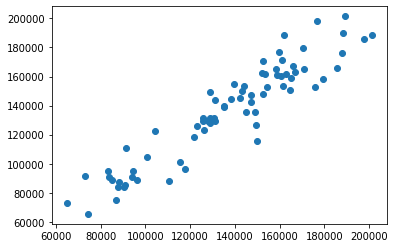

In [8]:
MSE=[]
APE=[]
MAE=[]
predicted=[]
true=[]
start = time.time()
transformer = Normalizer().fit(Varmax_df.iloc[:,:].drop(['DP'],axis=1))
Trans=transformer.transform(Varmax_df.iloc[:,:].drop(['DP'],axis=1))
trans_df=np.append(Trans,np.array(Varmax_df['DP']).reshape(len(Trans),1),1)
                   
for i in range(350,len(Varmax_df)):
    y_val=Varmax_df['DP'].iloc[i]
    mod = sm.tsa.VARMAX(trans_df[:i,[0,2,7]],order=(0,2), error_cov_type='diagonal')
    res = mod.fit()
    #pos_index=[i for i, j in enumerate(trans_df) if j == 'DP']
    y_predict=prediction['DP'].iloc[0]
    mse=(y_val-y_predict)**2
    ape=np.abs((y_val-y_predict)/(df['DP'].iloc[i]+df['Prev_pos'].iloc[i]))
    predicted.append(y_predict+df['Prev_pos'].iloc[i])
    true.append(y_val+df['Prev_pos'].iloc[i])
    MSE.append(mse)
    APE.append(ape)
    mae=np.abs(y_val-y_predict)
    MAE.append(mae)
end = time.time()
print('VAR Transformation: ')
print('MSE is ',np.mean(MSE))
print('Average Percentage Error is ' , np.mean(APE) )
print('Time elapsed: ',end-start)
print('MAE is ',np.mean(MAE))
plt.scatter(predicted,true)